<small>
Copyright (C) 2025, École Polytechnique Fédérale de Lausanne. All Rights Reserved.
</small>

---

# Exercise 8 | Explicit MPC

We revisit the MPC problem from exercise 4, where we considered the discrete-time linear time invariant system defined by

$$
x^+ = \begin{bmatrix}0.9752 & 1.4544 \\ -0.0327 & 0.9315 \end{bmatrix} x + \begin{bmatrix}0.0248 \\ 0.0327 \end{bmatrix} u
$$
with constraints
$$ \mathcal{X} = \{x \mid |x_1|\leq 5, |x_2|\leq 0.2 \},\quad \mathcal{U} = \{ u \mid |u| \leq 1.75 \} $$


## Problem 1 | Implement Explicit MPC

Your goal is to implement an explicit MPC controller for this system with a horizon of $N=10$ and a stage cost given by $l(x,u) := 10x^\top x+ u^\top u$.

In [ ]:
import numpy as np
# ==================================== NOTICE ======================================
# We have updated the mpt4py version to 0.1.5! 
# Please run pip install -r requirements.txt before starting the exercise.
# Check mpt4py version
from importlib.metadata import version
assert version("mpt4py") >= "0.1.5", "The mpt4py version is too low!"
# ==================================== NOTICE ======================================
from mpt4py import Polyhedron, PolyUnion
from mpt4py.functions import AffineFunction
from mpt4py.solvers import QP

import matplotlib.pyplot as plt
import pyvista as pv
%config InlineBackend.figure_format = 'retina'

# System dynamics
A = np.array([[0.9752, 1.4544], [-0.0327, 0.9315]])
B = np.array([[0.0248], [0.0327]])

# Initial condition
x0 = np.array([3, 0])

# Horizon and cost matrices
N = 10
Q = 10 * np.eye(2)
R = np.eye(1)

# Constraints
# u in U = { u | Mu <= m }
M = np.array([[1], [-1]])
m = np.array([1.75, 1.75])
U = Polyhedron.from_Hrep(M, m)
# x in X = { x | Fx <= f }
F = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
f = np.array([5, 0.2, 5, 0.2])
X = Polyhedron.from_Hrep(F, f)

We hereby introduce two features in *mpt4py* that will be used for the following exercise:

- **PolyUnion**: a `PolyUnion` class represents the union of a set of Polyhedra and used to represent the critical regions in the solution of a parametric QP. You can iterate through it by just treating the `PolyUnion` object as a list containing many `Polyhedron` objects.

- **Functions associated to polyhedron**: a polyhedron $\mathcal{P}$ can have multiple associated functions $f_1, f_2, \ldots, f_m$ that maps the element $\theta\in \mathcal{P}$ to $f_1(\theta), f_2(\theta), \ldots, f_m(\theta)$. This is useful when solving parametric QP, e.g., each critical region (represented by a polyhedron) can have associated functions $x(\theta)$ and $J(\theta)$, representing the optimal primal solution and objective, respectively.

One of the associated functions that is useful for this exercise is `AffineFunction`, which represents an affine function $f(\theta) = F\theta + g$. 
<!-- 
In *mpt4py*, the `Polyhedron` objects can have associated functions that maps the. One of the associated functions that is useful for this exercise is `AffineFunction`, which represents an affine function $f(x) = Fx + g$. 

 which can be used to store the mapping from the parameters to primal/dual variables. For example,  -->

In [2]:
P_example_1 = Polyhedron.from_Vrep([[0., 0.], [1., 0.], [0., 1.]])
P_example_1.add_function(
    func=AffineFunction(F=np.array([[-0.5, 0.5]]), g=np.array([1.])), 
    func_name='example_function'
    )

P_example_2 = Polyhedron.from_bounds([0., 0.], [1., 1.])
P_example_2 = Polyhedron.from_Vrep([[0., 0.], [-1., 0.], [0., 1.]])

P_example_2.add_function(
	func=AffineFunction(F=np.array([[0.5, 0.5]]), g=np.array([1.])), 
	func_name='example_function'
	)

polyunion = PolyUnion(P_example_1, P_example_2)

example_affine_func = P_example_1.get_function('example_function')
print("The example affine function is: Fx + g, where")
print("F =", example_affine_func.F)
print("g =", example_affine_func.g)

The example affine function is: Fx + g, where
F = [[-0.5  0.5]]
g = [1.]


You can easily visualize a associated function with `fplot()` (works only if the polyhedron is 2D and the function is a mapping from $\mathbb{R}^2$ to $\mathbb{R}$). Its usage is very similar to `plot()` and it supports both matplotlib and pyvista as backend.

In [3]:
plotter_example = pv.Plotter()
# polyunion.plot(plotter_example, color='blue', opacity=0.5)
# polyunion.fplot(plotter_example, func_name='example_function', color='red', opacity=0.5)
polyunion.plot(plotter_example, opacity=1.0)
polyunion.fplot(plotter_example, func_name='example_function', opacity=0.5)
plotter_example.show_bounds(grid=True)
plotter_example.show()

Widget(value='<iframe src="http://localhost:52974/index.html?ui=P_0x17fe4b980_0&reconnect=auto" class="pyvista…

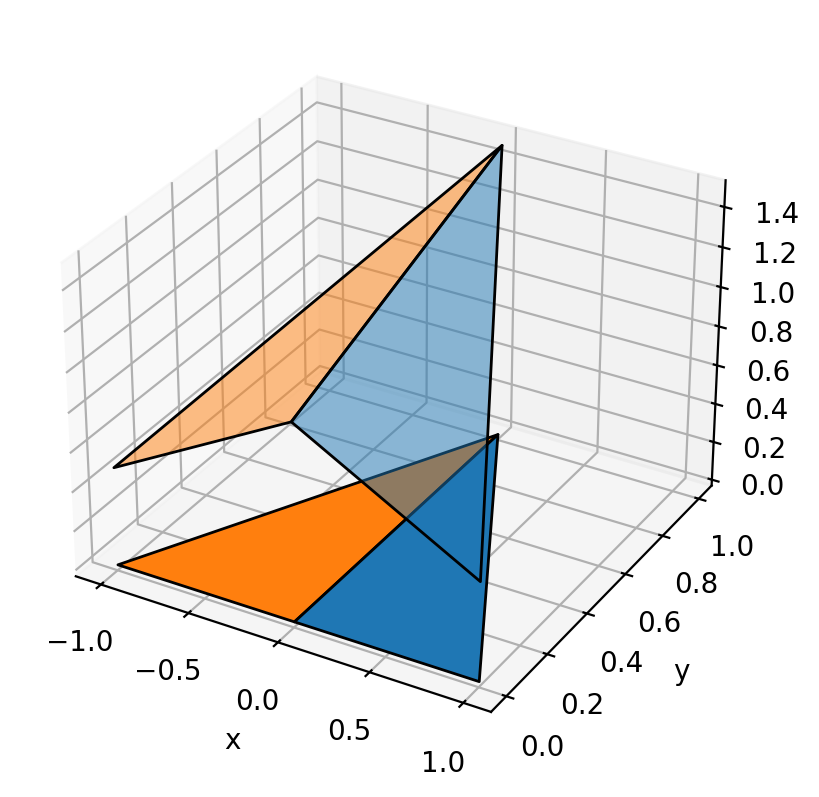

In [4]:
ax = plt.subplot(projection='3d')
# polyunion.plot(ax, color='blue', opacity=0.5)
# polyunion.fplot(ax, func_name='example_function', color='red', opacity=0.5)
polyunion.plot(ax, opacity=1.0)
polyunion.fplot(ax, func_name='example_function', opacity=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### Task 1

Formulate the MPC problem into a Parametric Quadratic Programming with the following form:

$$ \begin{aligned} \min_{z} \quad & \frac{1}{2} z^\top H z + (F\theta + f)^\top z\\  \text{s.t.}\quad & Az \leq b + B\theta, \\ & A_e z = b_e + E\theta . \end{aligned} $$



**Task:**  Implement the `H, F, f, A, b, B, Ae, be, E` arrays. The terminal set and cost is already handled by the provided code. You don't need to compute them again.

**Hint:** 

- When computing the matrices and vectors to formulate the parametric QP, you can reuse the code from Exercise 4, Task 2. The only difference is now you need to extract the parameters into seperate terms. 


In [5]:
# ========= [SOLUTION] ============
# Compute maximal invariant set
def max_invariant_set(A_cl, X: Polyhedron, max_iter = 30) -> Polyhedron:
	"""
	Compute invariant set for an autonomous linear time invariant system x^+ = A_cl x
	"""
	O = X
	itr = 1
	converged = False
	print('Computing maximum invariant set ...')
	while itr < max_iter:
		Oprev = O
		F, f = O.A, O.b
		# Compute the pre-set
		O = Polyhedron.from_Hrep(np.vstack((F, F @ A_cl)), np.vstack((f, f)).reshape((-1,)))
		O.minHrep(True)
		if O == Oprev:
			converged = True
			break
		print('Iteration {0}... not yet converged'.format(itr))
		itr += 1
	
	if converged:
		print('Maximum invariant set successfully computed after {0} iterations.'.format(itr))
	return O


class ExplicitMPC:
	def __init__(self, A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray, 
			  N: int, X: Polyhedron, U: Polyhedron):
		self.A = A
		self.B = B
		self.Q = Q
		self.R = R
		self.N = N
		self.X = X
		self.U = U

		self.Xf: Polyhedron = None
		self.Qf: np.ndarray = None
		self.critical_regions: PolyUnion = None

		self._compute_terminal_set_and_cost()

	def _compute_terminal_set_and_cost(self):
		"""Compute the terminal set and terminal cost matrix for the given MPC problem."""
		from control import dlqr
		K, Qf, _ = dlqr(self.A, self.B, self.Q, self.R)
		K = -K
		self.Qf = Qf

		A_cl = self.A + self.B @ K
		KU = Polyhedron.from_Hrep(self.U.A @ K, self.U.b)
		self.Xf = max_invariant_set(A_cl, self.X.intersect(KU))

	def compute_explicit_solution(self):
		"""Formulate the explicit MPC as a parametric QP and solve it."""
		nx, nu = self.B.shape
		N = self.N
		A, B = self.A, self.B
		Q, R, Qf = self.Q, self.R, self.Qf
		X, U, Xf = self.X, self.U, self.Xf

		# Equality constraints
		Ae_qp_left = np.kron(np.eye(N+1), np.eye(nx))
		Ae_qp_left += np.vstack([
			np.zeros((nx, nx*(N+1))),
			np.hstack([np.kron(np.eye(N), -A), np.zeros((N*nx, nx))])
		])
		Ae_qp_right = np.zeros((Ae_qp_left.shape[0], N*nu))
		Ae_qp_right[nx:, :] += np.kron(np.eye(N), -B)
		Ae_qp = np.hstack([Ae_qp_left, Ae_qp_right])
		be_qp = np.zeros((nx*(N+1),))
		E_qp = np.zeros((be_qp.shape[0], nx))
		E_qp[0:nx, 0:nx] = np.eye(nx)

		# Inequality constraints
		A_blocks = [np.kron(np.eye(N), X.A), Xf.A, np.kron(np.eye(N), U.A)]
		from scipy.linalg import block_diag
		A_qp = block_diag(*A_blocks)

		b_qp = np.concatenate([
			np.kron(np.ones((N, 1)), X.b).reshape(-1,),
			Xf.b,
			np.kron(np.ones((N, 1)), U.b).reshape(-1,)
		])
		B_qp = np.zeros((b_qp.shape[0], nx))

		# Cost function
		H_blocks = [np.kron(np.eye(N), Q), Qf, np.kron(np.eye(N), R)]
		H_qp = block_diag(*H_blocks)
		f_qp = np.zeros((H_qp.shape[0],))
		F_qp = np.zeros((f_qp.shape[0], nx))

		pqp = QP(
			H=H_qp, f=f_qp, pF=F_qp,
			Ae=Ae_qp, be=be_qp, pE=E_qp, 
			A=A_qp, b=b_qp, pB=B_qp,
			Ath=X.A, bth=X.b)
		self.critical_regions: PolyUnion = pqp.solve().regions

	def extract_feedback_law(self):
		"""
		Extract the feedback law from the explicit MPC solution by adding an affine function 
		called 'feedback_law' on to each critical region.
		"""
		# TODO: leave this until Task 2
		nx, nu = self.B.shape
		for region in self.critical_regions:
			# The primal solution function maps theta (x0) to all primal variables in the parametric QP
			pqp_primal_solution_function: AffineFunction = region.get_function('primal')
			K = pqp_primal_solution_function.F[(self.N+1)*nx : (self.N+1)*nx + nu, :]
			k = pqp_primal_solution_function.g[(self.N+1)*nx : (self.N+1)*nx + nu]
			feedback_function = AffineFunction(F=K, g=k)
			region.add_function(feedback_function, func_name='feedback_law')
		
	def evaluate(self, x0: np.ndarray) -> np.ndarray:
		"""Evaluate optimal input u0 given an initial state x0."""
		for region in self.critical_regions:
			if x0 in region:
				u0_func: AffineFunction = region.get_function('feedback_law')
				# return u0_func.evaluate(x0.reshape((-1, 1))).flatten()
				return u0_func.evaluate(x0).flatten()
				
		raise ValueError('The state x0 is outside the domain of the explicit MPC controller.')

explicit_mpc = ExplicitMPC(A, B, Q, R, N, X, U)
explicit_mpc.compute_explicit_solution()

Computing maximum invariant set ...
Iteration 1... not yet converged
Iteration 2... not yet converged
Maximum invariant set successfully computed after 3 iterations.
Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-20
Using a found active set [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 50]


### Task 2

Implement the `extract_feedback_law()` method in the above `ExplicitMPC` class, which adds an affine function onto each polyhrdral critical region representing the mapping from $x_0\in\mathbb{R}^2$ to the optimal input $u_0\in\mathbb{R}$.

Visualize the feedback law (code already provided, just run it).

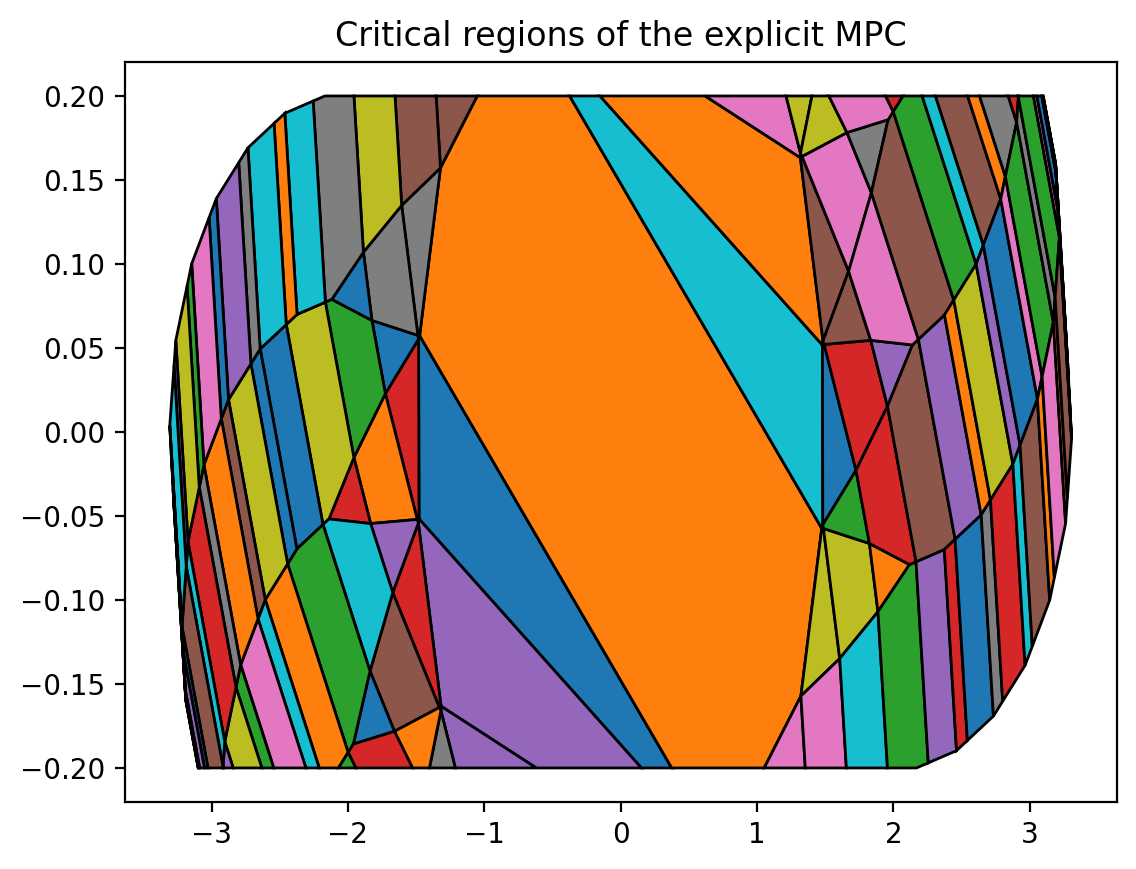

Widget(value='<iframe src="http://localhost:52974/index.html?ui=P_0x3032605f0_1&reconnect=auto" class="pyvista…

In [ ]:
# Visualization of the solution map (explicit control law)
explicit_mpc.extract_feedback_law()
# plot the critical regions in 2D
ax = plt.subplot()
explicit_mpc.critical_regions.plot(ax=ax)
ax.set_title('Critical regions of the explicit MPC')
plt.show()

# plot the explicit control law in 3D using pyvista
plotter = pv.Plotter()
explicit_mpc.critical_regions.fplot(ax=plotter, func_name='feedback_law')
plotter.show_bounds(grid=True)
# NOTICE: the following line scales y axis for better visualization. However, the y values are also scaled so they do not reveal the real values
plotter.set_scale(1, 10, 1)
plotter.show()

### Task 3

Implement the `evaluate()` method in the `ExplicitMPC` class using a sequential search.

Simulate the closed-loop system starting from the state $x = [3, ~ 0]^\top$. Confirm the constraints are met and the closed-loop trajectories are the same as those you obtained from Exercise 4.

In [7]:
# Closed-loop simulation of the state and input trajectories
def plot_trajs(t_traj_closed_loop: np.ndarray, 
			   x_traj_closed_loop: np.ndarray,
			   u_traj_closed_loop: np.ndarray):
	# Visualization of the trajectories
	fig, ax = plt.subplots(3, 1, sharex=True)
	ax[0].plot(t_traj_closed_loop, x_traj_closed_loop[0, :], label=r'$p$')
	ax[0].plot(t_traj_closed_loop, 5 * np.ones_like(t_traj_closed_loop), color='red', linestyle='--')
	ax[0].plot(t_traj_closed_loop, -5 * np.ones_like(t_traj_closed_loop), color='red', linestyle='--')
	ax[0].grid()
	ax[0].set_ylabel('x1')

	ax[1].plot(t_traj_closed_loop, x_traj_closed_loop[1, :], label=r'$v$')
	ax[1].plot(t_traj_closed_loop, 0.2 * np.ones_like(t_traj_closed_loop), color='red', linestyle='--')
	ax[1].plot(t_traj_closed_loop, -0.2 * np.ones_like(t_traj_closed_loop), color='red', linestyle='--')
	ax[1].grid()
	ax[1].set_ylabel('x2')

	ax[2].plot(t_traj_closed_loop[:-1], u_traj_closed_loop[0, :], label=r'$a$')
	ax[2].plot(t_traj_closed_loop[:-1], 1.75 * np.ones_like(t_traj_closed_loop[:-1]), color='red', linestyle='--')
	ax[2].plot(t_traj_closed_loop[:-1], -1.75 * np.ones_like(t_traj_closed_loop[:-1]), color='red', linestyle='--')
	ax[2].grid()
	ax[2].set_ylabel('u')
	ax[2].set_xlabel('steps')

	fig.suptitle('Closed-loop trajectory')
	fig.align_ylabels()
	plt.show()


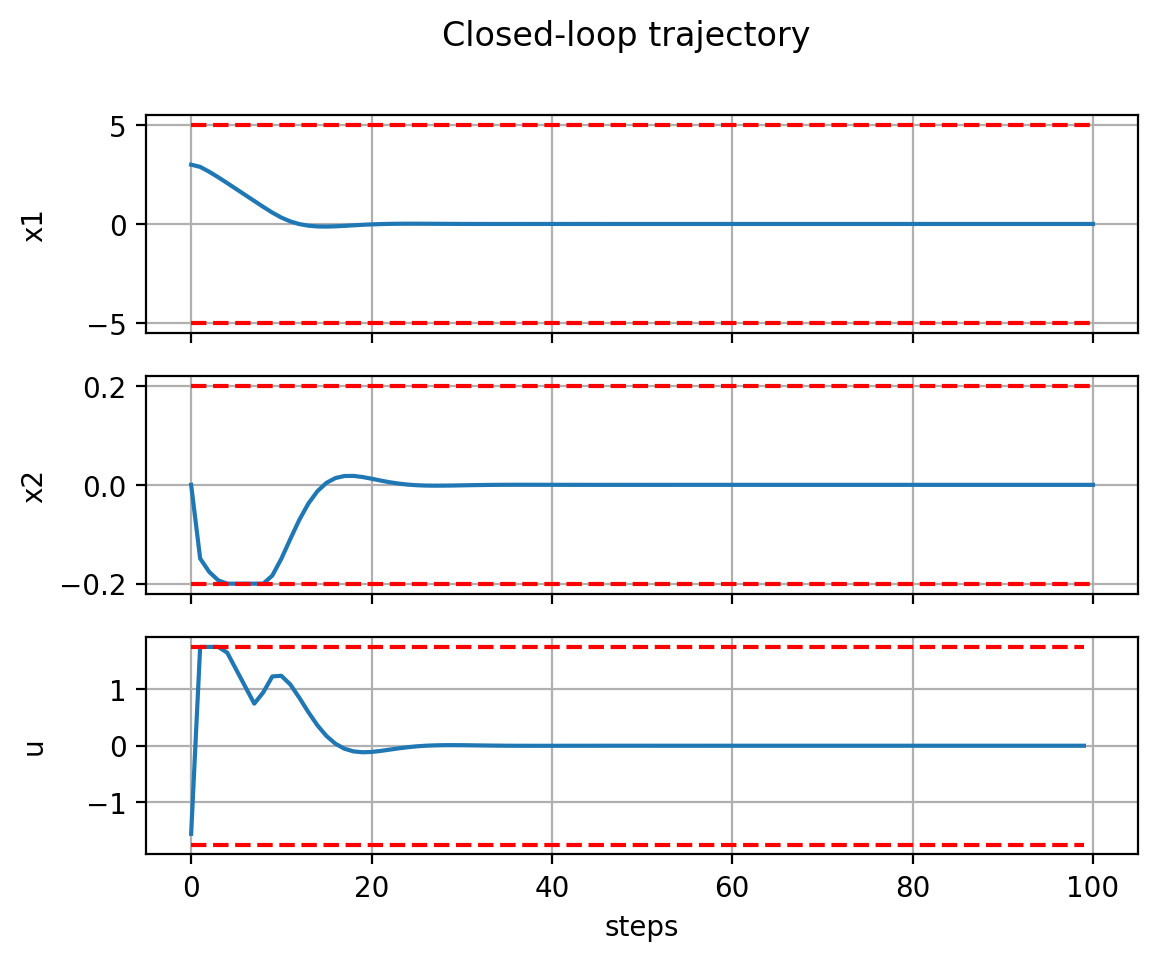

In [8]:
# ========= [SOLUTION] ============
nx, nu = B.shape
N_closed_loop = 100
t_traj_closed_loop = np.arange(0, N_closed_loop+1)
x_traj_closed_loop = np.zeros((nx, N_closed_loop+1))
u_traj_closed_loop = np.zeros((nu, N_closed_loop))

x0 = explicit_mpc.Xf.sample(1).flatten()
x0 = np.array([3.0, 0.0])
x_traj_closed_loop[:, 0] = x0
xk = x0

# Closed-loop simulation
for k in range(N_closed_loop):
	uk = explicit_mpc.evaluate(xk)
	xk = A @ xk + B @ uk
	x_traj_closed_loop[:, k+1] = xk.flatten()
	u_traj_closed_loop[:, k] = uk.flatten()

plot_trajs(t_traj_closed_loop, x_traj_closed_loop, u_traj_closed_loop)    
